In [1]:
############################################################################
################       █████   █████████  ███████████       ################ 
################      ░░███   ███░░░░░███░█░░░███░░░█       ################ 
################       ░███  ███     ░░░ ░   ░███  ░        ################ 
################       ░███ ░███             ░███           ################ 
################       ░███ ░███             ░███           ################ 
################       ░███ ░░███     ███    ░███           ################ 
################       █████ ░░█████████     █████          ################ 
################       ░░░░░   ░░░░░░░░░     ░░░░░          ################ 
############################################################################
########                IRI PROGRESSION MODEL (MPEDG)             ##########
################           Project: R27-252 EV             #################
########     Originally written by: Aravind Ramakhrishnan        ###########
############################################################################

# Created on Sat May 28 21:10:59 2022
# Last modified on Fri Jul 27 9:10:59 2024
# @author: Johann-Cardenas

In [147]:
# Import libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# Import modules
import Temperature_Parameters as TP
import Expected_strain as ES
import Rut_calc_RP_v4 as RC_V4
import Fatigue_calc as FC
import IRI_calc

# Start time tracker
start = time.time()

### **Design Traffic**

In [148]:
# Annual Average Daily Traffic (AADT)
Total_AADT = 35000
# Class Traffic Distribution
Class = [0.88, 0.07, 0.05]   # [PV, SU, MU]
# Design Lane Distribution Factors|
Design_ADT = [0.32, 0.45, 0.45] 

AADT_Class = [int(Total_AADT * i) for i in Class]
AADT_Class

[30800, 2450, 1750]

#### **Minimum Structural Design Traffic**

In [149]:
AADT_Minimum = [0, 500, 1500] # [PV, SU, MU]

#### **Actual Structural Design Traffic**

In [150]:
AADT_Actual = [int(Total_AADT * i) for i in Class]

### **Traffic Factor (54.5)**
The traffic factor represents the total number of 18-kip ESALs, expressed in millions, that a given pavement may be expected to carry throughout its entire service life.
 - A traffic factor of 0.5 (0.5-100) controls the design thickness at lower limits.
 - Limiting Strain Criterion Design control the maximum design thickness at higher limits (6-18in.)

In [160]:
DP = 20  # Design Period
ESAL_factors  = [0.0004, 0.363, 1.322]  # [PV, SU, MU]
CDWA = 1.0
CDWB = 1.0
TF_coeff = [0.15, 132.50, 482.53 / CDWB]


TF_Actual = DP * sum(np.array(TF_coeff) * np.array(Design_ADT) * np.array(AADT_Actual)) / 1e06
TF_Actual = TF_Actual / CDWA
TF_Minimum = DP * sum(np.array(TF_coeff) * np.array(Design_ADT) * np.array(AADT_Minimum)) / 1e06

TF_Minimum, TF_Actual

(7.110405, 10.5510405)

In [161]:
CDWA = 0.70
CDWB = 1.00
TF_coeff = [0.15, 132.50, 482.53 / CDWB]


TF_A = (DP * sum(np.array(TF_coeff) * np.array(Design_ADT) * np.array(AADT_Actual)) / 1e06) / CDWA
TF_Actual, TF_A

(10.5510405, 15.072915)

In [162]:
CDWA = 1.00
CDWB = 0.70
TF_coeff = [0.15, 132.50, 482.53 / CDWB]


TF_B = (DP * sum(np.array(TF_coeff) * np.array(Design_ADT) * np.array(AADT_Actual)) / 1e06 )/ CDWA
TF_Actual, TF_B

(10.5510405, 13.808118)

In [177]:
# Traffic Factor Equation
import math

K2 = 3.5  # K2 value
K1 = 10 ** ((1.1784 - K2) / 0.329)  # K1 based on K2

def calculate_Nf(e11, K1, K2):
    Nf = K1 * (1 / e11) ** K2
    return Nf/(4.7 * 1e06)

def calculate_e11(Nf, K1, K2):
    e11 = (K1 / (Nf * (4.7 * 1e06))) ** (1 / K2)
    return e11

# Example usage:
e11 = 73.78e-06  # example strain value

Nf = calculate_Nf(e11, K1, K2)
print(f"The number of load repetitions (Nf) is: {Nf}")

The number of load repetitions (Nf) is: 5.414793632554535


In [178]:
# Calculate e11 for TF_Actual, TF_A and TF_B
e11_Actual = calculate_e11(TF_Actual, K1, K2)
e11_A = calculate_e11(TF_A, K1, K2)
e11_B = calculate_e11(TF_B, K1, K2)

e11_Actual * 1E06, e11_A* 1E06, e11_B* 1E06

(60.97662730468825, 55.068810594221524, 56.465187009085305)

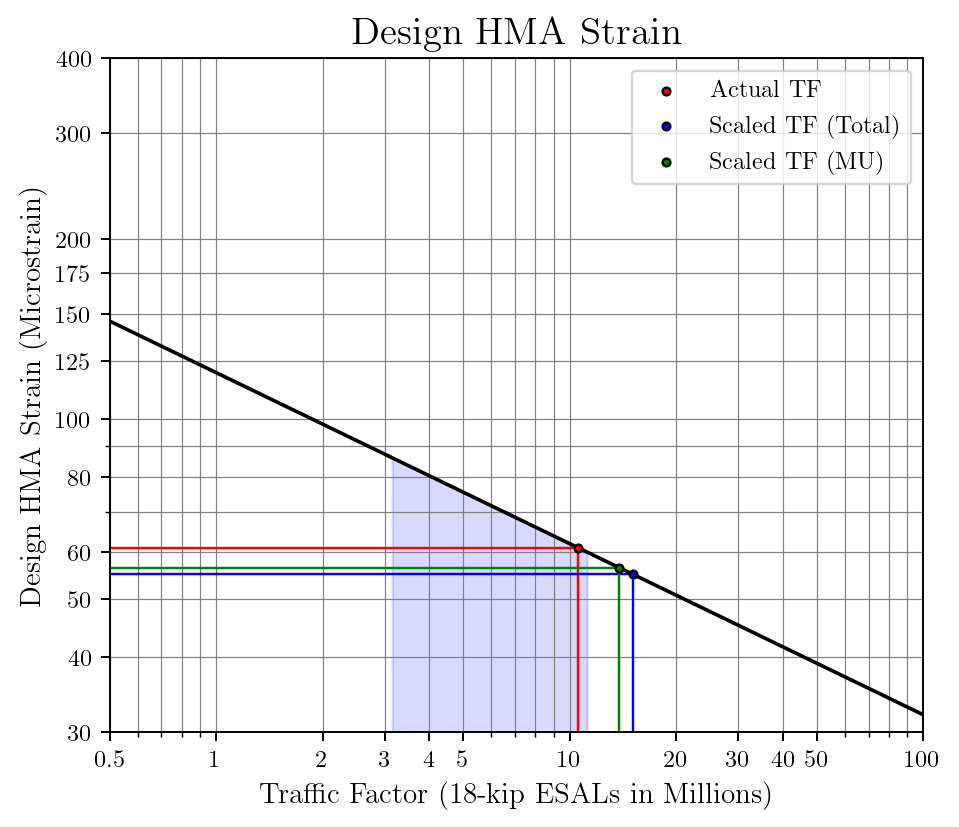

In [198]:
# Create a plot Nf vs. e11
e11 = np.linspace(30e-06, 400e-06, 100)
Nf = calculate_Nf(e11, K1, K2)

# Plot limits for FD Simulations
Nf_A = calculate_Nf(56.65E-06, K1, K2)
Nf_B = calculate_Nf(86.80E-06, K1, K2)

fig = plt.figure(figsize=(6, 5), dpi=175)
plt.plot(Nf, e11 * 1e06, color='black', linewidth=1.5)

# Color the area between Nf_A and Nf_B below the curve
plt.fill_between(Nf, e11 * 1e06, 0.5, where=(Nf > Nf_B) & (Nf < Nf_A), color='blue', alpha=0.15)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xscale('log')
plt.yscale('log')
plt.xticks([0.5, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100], 
           [0.5, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100])
plt.yticks([30, 40, 50, 60, 80, 100, 125, 150, 175, 200, 300, 400], 
           [30, 40, 50, 60, 80, 100, 125, 150, 175, 200, 300, 400])

plt.xlim(0.5, 100)
plt.ylim(30, 400)

# Plot TF_Actual and e11_Actual
plt.scatter(TF_Actual, e11_Actual * 1e06, color='red', s=10, label='Actual TF', edgecolors='black', zorder=3)
plt.plot([TF_Actual, TF_Actual], [0, e11_Actual * 1e06], color='red', linestyle='-', linewidth=1.0, zorder=2)
plt.plot([0, TF_Actual], [e11_Actual * 1e06, e11_Actual * 1e06], color='red', linestyle='-', linewidth=1.0, zorder=2)

plt.scatter(TF_A, e11_A * 1e06, color='blue', s=10, label='Scaled TF (Total)', edgecolors='black', zorder=3)
plt.plot([TF_A, TF_A], [0, e11_A * 1e06], color='blue', linestyle='-', linewidth=1.0, zorder=2)
plt.plot([0, TF_A], [e11_A * 1e06, e11_A * 1e06], color='blue', linestyle='-', linewidth=1.0, zorder=2)

plt.scatter(TF_B, e11_B * 1e06, color='green', s=10, label='Scaled TF (MU)', edgecolors='black', zorder=3)
plt.plot([TF_B, TF_B], [0, e11_B * 1e06], color='green', linestyle='-', linewidth=1.0, zorder=2)
plt.plot([0, TF_B], [e11_B * 1e06, e11_B * 1e06], color='green', linestyle='-', linewidth=1.0, zorder=2)


plt.xlabel('Traffic Factor (18-kip ESALs in Millions)', fontsize = 12)
plt.ylabel('Design HMA Strain (Microstrain)', fontsize = 12)
plt.title('Design HMA Strain', fontsize = 16, fontweight = 'bold')
plt.grid(which='major', color='grey', linestyle='-', linewidth=0.50)
plt.grid(which='minor', color='grey', linestyle='-', linewidth=0.50)
plt.minorticks_on()
plt.legend(loc='best')
plt.show()


#### **Note**
The Full-Depth cases simulated yielded values of $e_{11}$ between 56.65 $\mu \epsilon$ and 86.80 $\mu \epsilon$.